## Convert position x,y,z TEME to lat, long

In [1]:
# Import libraries
import json
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt

# For coordinate system conversion
from astropy.time import Time
from astropy.coordinates import TEME, EarthLocation, GCRS, CartesianRepresentation, ITRS
import astropy.units as u

### Load data

In [2]:
# Load position data
# epoch,position_teme_km_x,position_teme_km_y,position_teme_km_z
# Read data from csv
position_df=pd.read_csv("data/position_telemetry")

# A brief analysis of the data has been done in the uptime notebook

### Transform coordinates algorithm

Code to do the convertion:

In [3]:
# This code is from internet

def teme_to_latlon(X, Y, Z, dt):
    # Convert the datetime to an Astropy Time object
    t = Time(dt)
    
    # Create a Cartesian representation of the TEME coordinates
    teme_cartesian = CartesianRepresentation(X * u.m, Y * u.m, Z * u.m)
    
    # Create a TEME coordinate object
    teme_coords = TEME(teme_cartesian, obstime=t)
    
    # Transform TEME to ITRS (International Terrestrial Reference System, similar to ECEF)
    itrs_coords = teme_coords.transform_to(ITRS(obstime=t))
    
    # Convert ITRS to EarthLocation to get latitude and longitude
    itrs_location = EarthLocation.from_geocentric(itrs_coords.x, itrs_coords.y, itrs_coords.z)
    lat = itrs_location.lat.degree
    lon = itrs_location.lon.degree
    
    return lat, lon

In [4]:
# One sample
t=position_df.epoch[300]
t=datetime.fromisoformat(t)
x_teme=position_df.position_teme_km_x[300]*1000
y_teme=position_df.position_teme_km_y[300]*1000
z_teme=position_df.position_teme_km_z[300]*1000
coordinates_in_lat_long=teme_to_latlon(x_teme,y_teme,z_teme,t)

In [5]:
coordinates_in_lat_long

(-62.14135963029011, 57.27120188453973)

In [6]:
n=position_df.shape[0]
# Iteration for all the dataframe
latitude=[]
longitude=[]
timestamp=[]
for i in range(n):
    t=position_df.epoch[i]
    t=datetime.fromisoformat(t)
    x_teme=position_df.position_teme_km_x[i]*1000
    y_teme=position_df.position_teme_km_y[i]*1000
    z_teme=position_df.position_teme_km_z[i]*1000
    coordinates_in_lat_long=teme_to_latlon(x_teme,y_teme,z_teme,t)
    timestamp.append(t)
    latitude.append(coordinates_in_lat_long[0])
    longitude.append(coordinates_in_lat_long[1])

In [7]:
# Dictionary creation
dict = {"timestamp":timestamp, "latitude":latitude , "longitude": longitude}

In [8]:
# Dataframe creation based on dict.
df = pd.DataFrame(dict)

In [9]:
#df.to_pickle("latlong_dataframe.pkl")

In [10]:
df.describe()

,latitude,longitude
count,259201.000000,259201.000000
mean,2.656005,-0.152755
std,52.200465,102.433905
min,-82.539141,-179.999496
25%,-43.377218,-87.553466
50%,2.727651,0.000000
75%,48.738278,87.045135
max,90.000000,179.998504


In [11]:
df.head()

,timestamp,latitude,longitude
0,2022-04-08 04:23:34+00:00,53.592879,-106.111952
1,2022-04-08 04:23:44+00:00,54.207012,-106.389137
2,2022-04-08 04:23:54+00:00,54.820586,-106.673393
3,2022-04-08 04:24:04+00:00,55.433575,-106.965095
4,2022-04-08 04:24:14+00:00,56.045952,-107.264645


In [12]:
df.tail()

,timestamp,latitude,longitude
259196,2022-05-08 04:22:54+00:00,-71.815025,60.718562
259197,2022-05-08 04:23:04+00:00,-72.382852,59.815611
259198,2022-05-08 04:23:14+00:00,-72.946651,58.857459
259199,2022-05-08 04:23:24+00:00,-73.506017,57.838896
259200,2022-05-08 04:23:34+00:00,-74.060491,56.754113


In [13]:
df["latitude"].isnull().sum()

0

In [14]:
df["longitude"].isnull().sum()

0

### Plot some ground tracks

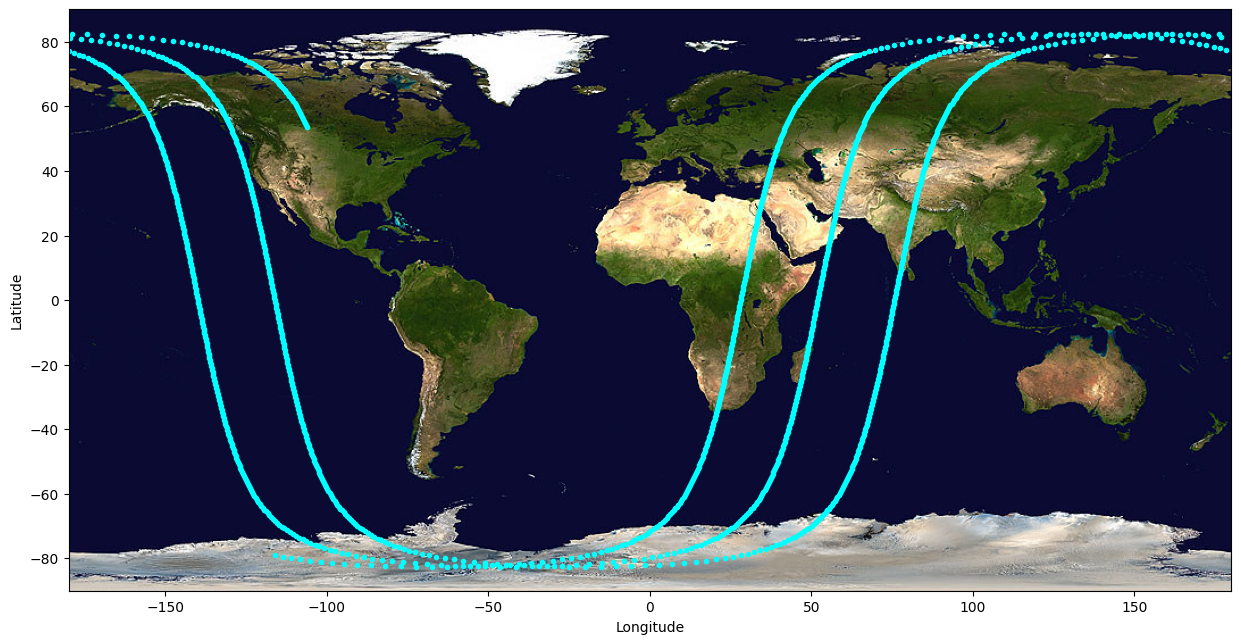

In [15]:
import matplotlib.image as mpimg
# Read the image
img = mpimg.imread('earth_blue_marble.jpg')

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(longitude[0:1500], latitude[0:1500], c='cyan',marker='.')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.imshow(img, extent=[-180, 180, -90, 90])

## Telemetry and Uptime

### Telemetry and uptime: merge

In [16]:
# Load telemetry dataframe computed in uptime.ipynb
utdf=pd.read_pickle("full_data_frame.pkl")

In [17]:
utdf.head()

,id,boot_start_dt,booting_time,active_time,cooldown_time,total_duration,window_end_dt,middle_date
0,0,2022-04-08 04:44:12.581000+00:00,169.994,50.016,19.932,239.942,2022-04-08 04:48:12.523000+00:00,2022-04-08 04:46:12.552000+00:00
1,1,2022-04-08 05:59:13.201000+00:00,190.177,409.878,20.312,620.367,2022-04-08 06:09:33.568000+00:00,2022-04-08 06:04:23.384500+00:00
2,2,2022-04-08 06:23:34.131000+00:00,180.251,430.202,9.868,620.321,2022-04-08 06:33:54.452000+00:00,2022-04-08 06:28:44.291500+00:00
3,3,2022-04-08 07:38:31.795000+00:00,180.050,430.016,9.972,620.038,2022-04-08 07:48:51.833000+00:00,2022-04-08 07:43:41.814000+00:00
4,4,2022-04-08 08:30:49.805000+00:00,179.999,420.086,20.048,620.133,2022-04-08 08:41:09.938000+00:00,2022-04-08 08:35:59.871500+00:00


In [18]:
df.head()

,timestamp,latitude,longitude
0,2022-04-08 04:23:34+00:00,53.592879,-106.111952
1,2022-04-08 04:23:44+00:00,54.207012,-106.389137
2,2022-04-08 04:23:54+00:00,54.820586,-106.673393
3,2022-04-08 04:24:04+00:00,55.433575,-106.965095
4,2022-04-08 04:24:14+00:00,56.045952,-107.264645


In [19]:
df["timestamp"][0] < utdf["middle_date"][0]

True

Code to find lat, long coordinates of the middle of the window.

(It uses a linear search approach, it can be improved.)

In [20]:
rows_telemetry=utdf.shape[0]
rows_lat_long= df.shape[0]
list_lat=[]
list_long=[]
j=0
for i in range(rows_telemetry):
    found=False
    while j < (rows_lat_long-1) and not found:
        low_limit=df["timestamp"][j]        #data from lat long dataframe
        upper_limit=df["timestamp"][j+1]    #data from lat long dataframe
        target= utdf["middle_date"][i]      #data from uptime dataframe
        if (low_limit < target <= upper_limit):
            list_lat.append(df["latitude"][j])
            list_long.append(df["longitude"][j])
            found=True
        j+=1


In [21]:
utdf["latitude"]=list_lat
utdf["longitude"]=list_long

### Telemetry and uptime: analysis

In [22]:
# OBC failed in the booting sequence, in these events there is no uptime of the obc
failed_boots_mask=utdf["active_time"]=="failed"
failed_boots=utdf[failed_boots_mask]

In [23]:
failed_boots

,id,boot_start_dt,booting_time,active_time,cooldown_time,total_duration,window_end_dt,middle_date,latitude,longitude
32,35,2022-04-09 15:39:11.042000+00:00,170.161,failed,failed,170.161,2022-04-09 15:42:01.203000+00:00,2022-04-09 15:40:36.122500+00:00,90.000000,0.000000
40,44,2022-04-10 00:28:40.617000+00:00,189.893,failed,failed,189.893,2022-04-10 00:31:50.510000+00:00,2022-04-10 00:30:15.563500+00:00,90.000000,0.000000
505,547,2022-04-30 23:39:24.382000+00:00,169.829,failed,failed,169.829,2022-04-30 23:42:14.211000+00:00,2022-04-30 23:40:49.296500+00:00,-34.350955,-20.093810
570,620,2022-05-04 00:30:49.748000+00:00,190.034,failed,failed,190.034,2022-05-04 00:33:59.782000+00:00,2022-05-04 00:32:24.765000+00:00,-69.080119,-18.117287


In [24]:
exclude_failed_boots_mask=utdf["active_time"]!="failed"
exclude_failed_boots=utdf[exclude_failed_boots_mask]

In [25]:
# OBC very short active duration less than 25 seconds (not sure it this is a failure)
short_time_mask=exclude_failed_boots["active_time"]<25
short_duration=exclude_failed_boots[short_time_mask]

In [26]:
short_duration

,id,boot_start_dt,booting_time,active_time,cooldown_time,total_duration,window_end_dt,middle_date,latitude,longitude
85,92,2022-04-12 00:45:50.035000+00:00,190.144,20.012,30.124,240.280,2022-04-12 00:49:50.315000+00:00,2022-04-12 00:47:50.175000+00:00,51.655484,147.595485
131,139,2022-04-14 00:00:33.129000+00:00,189.680,20.124,29.981,239.785,2022-04-14 00:04:32.914000+00:00,2022-04-14 00:02:33.021500+00:00,41.178194,-37.183973
167,177,2022-04-15 13:36:40.724000+00:00,190.034,20.159,29.89,240.083,2022-04-15 13:40:40.807000+00:00,2022-04-15 13:38:40.765500+00:00,-70.150590,146.619107
354,384,2022-04-24 04:35:49.907000+00:00,189.926,20.072,29.842,239.840,2022-04-24 04:39:49.747000+00:00,2022-04-24 04:37:49.827000+00:00,67.112676,-117.535579
434,470,2022-04-27 19:08:38.930000+00:00,190.186,19.881,29.973,240.040,2022-04-27 19:12:38.970000+00:00,2022-04-27 19:10:38.950000+00:00,-73.956145,-164.770830
577,627,2022-05-04 08:00:38.253000+00:00,190.188,19.789,30.198,240.175,2022-05-04 08:04:38.428000+00:00,2022-05-04 08:02:38.340500+00:00,-11.230569,27.815180
645,700,2022-05-07 08:30:24.911000+00:00,189.908,19.966,30.197,240.071,2022-05-07 08:34:24.982000+00:00,2022-05-07 08:32:24.946500+00:00,71.610367,178.642213


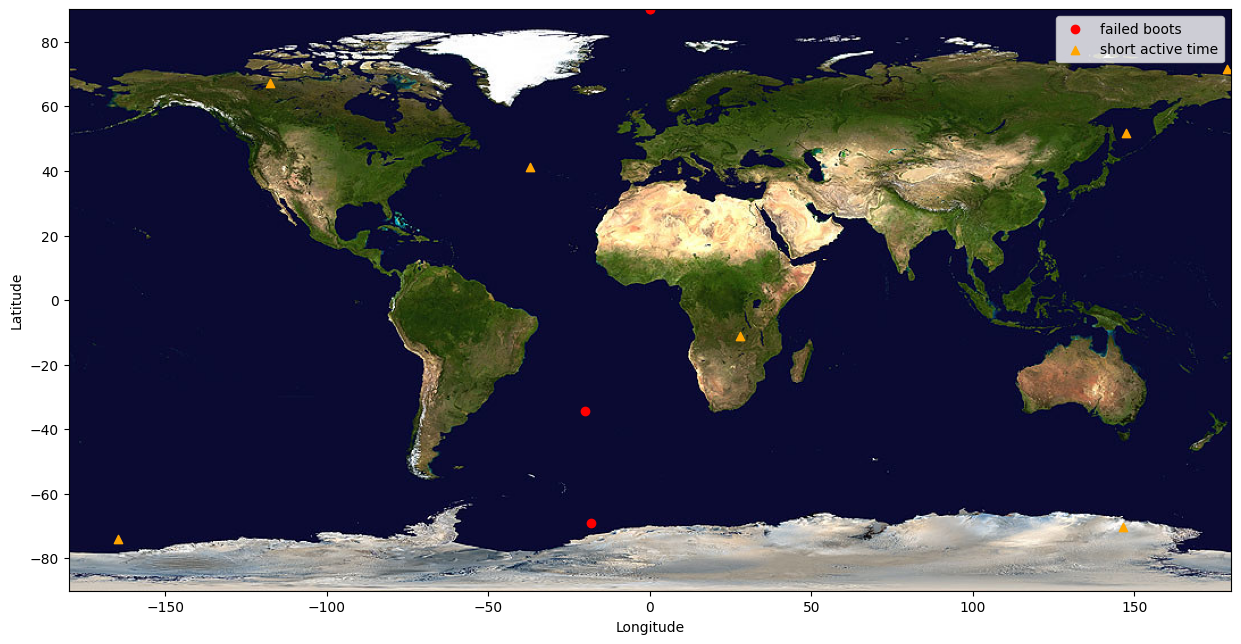

In [27]:
# Read the image
img = mpimg.imread('earth_blue_marble.jpg')

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(failed_boots["longitude"], failed_boots["latitude"], c='red',marker='o',label="failed boots")
ax.scatter(short_duration["longitude"], short_duration["latitude"], c='orange',marker='^',label="short active time")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend() 

ax.imshow(img, extent=[-180, 180, -90, 90])

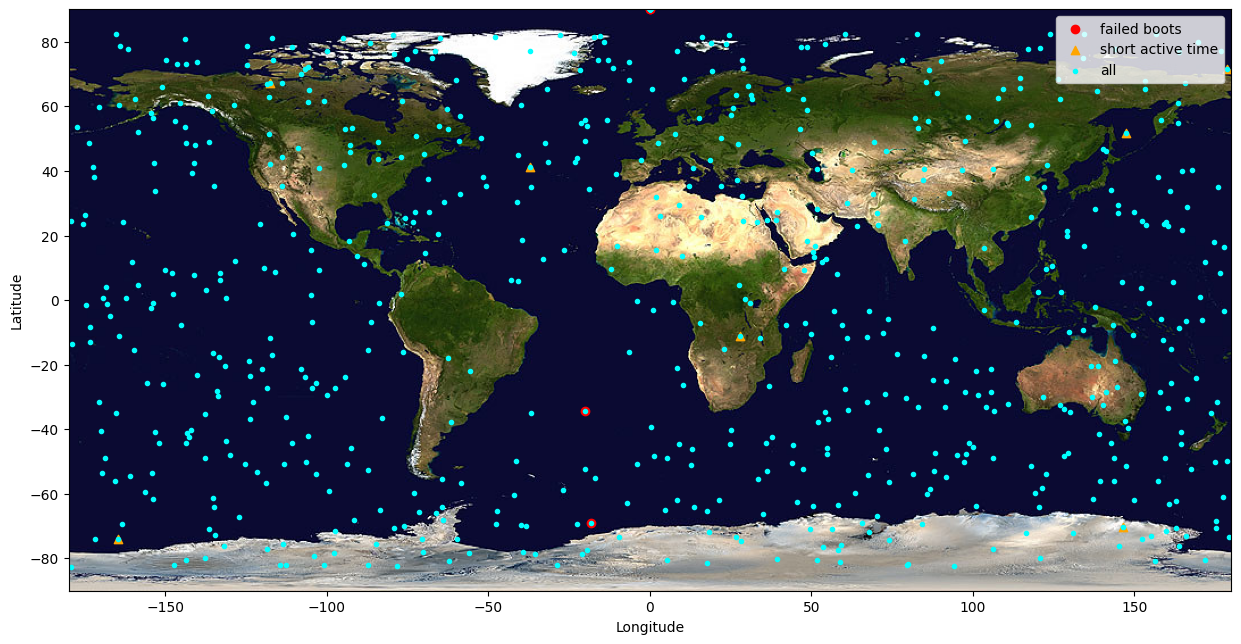

In [30]:
# Read the image
img = mpimg.imread('earth_blue_marble.jpg')

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(failed_boots["longitude"], failed_boots["latitude"], c='red',marker='o',label="failed boots")
ax.scatter(short_duration["longitude"], short_duration["latitude"], c='orange',marker='^',label="short active time")
ax.scatter(utdf["longitude"], utdf["latitude"], c='cyan',marker='.',label="all")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='upper right') 

ax.imshow(img, extent=[-180, 180, -90, 90])